In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

from scipy.ndimage.measurements import label

from sklearn.model_selection import train_test_split

from moviepy.editor import ImageSequenceClip, VideoFileClip
from IPython.display import HTML

In [2]:
VEHICLE_IMAGES_PATH = "../data/vehicles"
NON_VEHICLE_IMAGES_PATH = "../data/non-vehicles" 

def load_images(globr):
    images = []

    for f in glob.glob(globr):
        img = cv2.imread(f)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)

    return np.array(images)

def load_vehcile_non_vehilce_images():
    non_vehicle_images = None
    vehicle_images = None
    
    non_vehicle_globs = ["/Extras/*.png", 
                         "/GTI/*.png"]
    
    vehicle_globs = ["/GTI_Far/*.png", 
                     "/GTI_Left/*.png", 
                     "/GTI_MiddleClose/*.png", 
                     "/GTI_Right/*.png", 
                     "/KITTI_extracted/*.png"]
    
    for glob_tmp in non_vehicle_globs:
        globr = "%s%s" % (NON_VEHICLE_IMAGES_PATH, glob_tmp)
        images = load_images(globr)
        
        print ("Loaded : ", globr, " - ", images.shape)
        
        if non_vehicle_images is None:
            non_vehicle_images = images
        else:    
            non_vehicle_images = np.concatenate([non_vehicle_images, images], axis=0)
        
    for glob_tmp in vehicle_globs:
        globr = "%s%s" % (VEHICLE_IMAGES_PATH, glob_tmp)
        images= load_images(globr)
        
        print ("Loaded : ", globr, " - ", images.shape)
        
        if vehicle_images is None:
            vehicle_images = images
        else:
            vehicle_images = np.concatenate([vehicle_images, images], axis=0)
        
    return vehicle_images, non_vehicle_images

In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    """
    Returns Hog features and visualization for a given image
    """
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    
    features = hog(img, orientations=orient, 
                    pixels_per_cell=(pix_per_cell, pix_per_cell),
                    cells_per_block=(cell_per_block, cell_per_block), 
                    transform_sqrt=True, 
                    visualise=vis, feature_vector=feature_vec)
    return features

In [4]:
def bin_spatial(img, size=(64, 64)):
    """
    Computes the binned color features
    """
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [5]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    """
    Computes the color histogram features
    """
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [6]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    """
    Extracts features froma list of images
    """
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # Read in each one by one
        #image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [7]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """
    Saves and returns the sliding window coordinates (x,y) for an image
    Function that takes an image, start and stop positions in both x and y, 
    window size (x and y dimensions),  and overlap fraction (for both x and y)
    """
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [8]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [9]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [10]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    # Return the image
    return img

In [11]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [12]:

color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 32  # HOG orientations
pix_per_cell = 15 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"


spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 680] # Min and max in y to search in slide_window()

def get_features():
    vehicle_images, non_vehilce_images = load_vehcile_non_vehilce_images()
    
    print ("vehicle_images : ", vehicle_images.shape, "non_vehilce_images : ", non_vehilce_images.shape)

    car_features = extract_features(vehicle_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

    notcar_features = extract_features(non_vehilce_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

    
    print ("car features : ", len(car_features), "notcar_features : ", len(notcar_features))
    return car_features, notcar_features

In [13]:
def train_classifier(X, y):
    
    print ("Features : ", X.shape[0], " Labels : ", y.shape[0])
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)

    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)
    
    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    
    return (X_scaler, svc)

In [14]:
# Define the labels vector
car_features, notcar_features = get_features()

X = np.vstack((car_features, notcar_features)).astype(np.float64) 
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

X_scaler, svc = train_classifier(X, y) 

Loaded :  ../data/non-vehicles/Extras/*.png  -  (5068, 64, 64, 3)
Loaded :  ../data/non-vehicles/GTI/*.png  -  (3900, 64, 64, 3)
Loaded :  ../data/vehicles/GTI_Far/*.png  -  (834, 64, 64, 3)
Loaded :  ../data/vehicles/GTI_Left/*.png  -  (909, 64, 64, 3)
Loaded :  ../data/vehicles/GTI_MiddleClose/*.png  -  (419, 64, 64, 3)
Loaded :  ../data/vehicles/GTI_Right/*.png  -  (664, 64, 64, 3)
Loaded :  ../data/vehicles/KITTI_extracted/*.png  -  (5966, 64, 64, 3)
vehicle_images :  (8792, 64, 64, 3) non_vehilce_images :  (8968, 64, 64, 3)
car features :  8792 notcar_features :  8968
Features :  17760  Labels :  17760
Using: 32 orientations 15 pixels per cell and 2 cells per block
Feature vector length: 6624
23.75 Seconds to train SVC...
Test Accuracy of SVC =  0.9913


In [15]:
from collections import deque

global DEBUG
DEBUG = False

global heatmap_history
heatmap_history = deque(maxlen=10)

global fname
fname = "./output_images/test"

window_sizes = {
                #"tiny" : [(32, 32), (0.5, 0.5), (400, 580)],
                "small" : [(64, 64), (0.5, 0.5), [400, 680]],
                "medium" : [(128, 128), (0.5, 0.5), [400, 680]],
                "large" : [(192, 192), (0.0, 0.0), [400, 680]], 
                #"large" : [(160, 160), (0.0, 0.0)],
                #"xlarge" : [(256, 256), (0.0, 0.0), [400, 680]]
               }
    
def image_processing_pipeline(image):
    
    if DEBUG:
        print (image.shape)
        plt.imshow(image)
        plt.show()
        
    if DEBUG:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        # Call our function with vis=True to see an image output
        features, hog_image = get_hog_features(gray, orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)


        # Plot the examples
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(image, cmap='gray')
        plt.title('Example Car Image')
        plt.subplot(122)
        cv2.imwrite('%s_%s.png' % (fname, "hog"), hog_image)
        plt.imshow(hog_image, cmap='gray')
        plt.title('HOG Visualization')
        plt.show()
        
    if DEBUG:
        feature_vec = bin_spatial(image, size=(32, 32))
        # Plot features
        plt.plot(feature_vec)
        plt.title('Spatially Binned Features')
        plt.show()
    
    on_windows = []
    
    for wskey in window_sizes.keys():
        # for each of the window sizes defined, slide and get the
        # window
        
        ws = window_sizes.get(wskey)
        
        windows = slide_window(image, x_start_stop=[600, 1280], y_start_stop=ws[2], 
                        xy_window=ws[0], xy_overlap=ws[1])
                       
        window_img = draw_boxes(np.copy(image), windows, color=(0, 0, 255), thick=6)
        
        if DEBUG:
            plt.imshow(window_img)
            print ("Windows sizing %s" % wskey)
            cv2.imwrite('%s_%s.png' % (fname, wskey), window_img)
            plt.show()  
   
        for window in windows:
            # resize the image
            test_img = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        
            # extract features
            features = extract_features([test_img], color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
            
            features = features[0]
            
            # normalize features
            test_features = X_scaler.transform(np.array(features).reshape(1, -1))
        
            # predict using the classifier
            prediction = svc.predict(test_features)
        
            # if prediction is a car, store the window
            if prediction == 1:
                on_windows.append(window)
        
    window_img = draw_boxes(np.copy(image), on_windows, color=(0, 0, 255), thick=6)                    

    if DEBUG:
        cv2.imwrite('%s_%s.png' % (fname, "detected"), window_img)
        plt.imshow(window_img)
        plt.show()
        
    heatmap = np.zeros_like(image[:, :, 0]).astype(np.float)  
    
    heatmap = add_heat(heatmap, on_windows)
    heatmap = np.clip(heatmap, 0, 255)

    # standardise heatmap -
    heatmap_std = heatmap.std(ddof=1)
    if heatmap_std != 0.0:
        heatmap = (heatmap - heatmap.mean())/heatmap_std

    heatmap = apply_threshold(heatmap, np.max([heatmap.std(), 1]))
    
    heatmap_history.append(heatmap)
    
    heatmap = sum(heatmap_history)/ len(heatmap_history)
        
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    if DEBUG:
        fig = plt.figure()
        plt.subplot(121)
        cv2.imwrite('%s_%s.png' % (fname, "output"), draw_img)
        plt.imshow(draw_img)
        plt.title('Car Positions')
        plt.subplot(122)
        cv2.imwrite('%s_%s.png' % (fname, "heatmap"), heatmap)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        fig.tight_layout()
    
        plt.show()
        
    return draw_img

(720, 1280, 3)


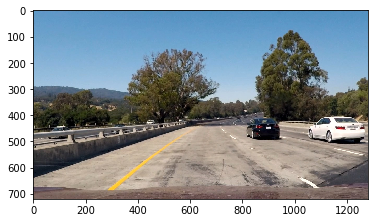

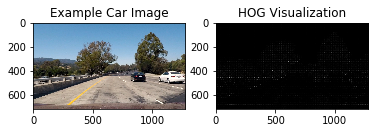

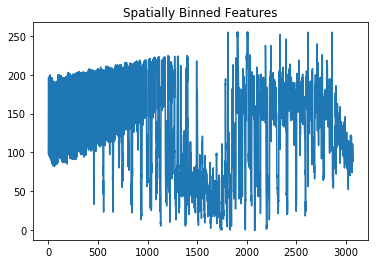

Windows sizing small


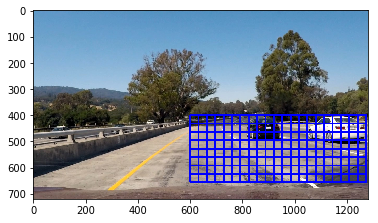

Windows sizing medium


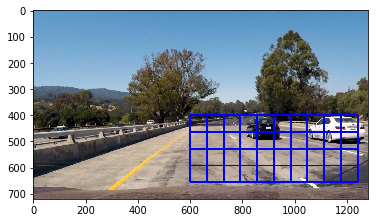

Windows sizing large


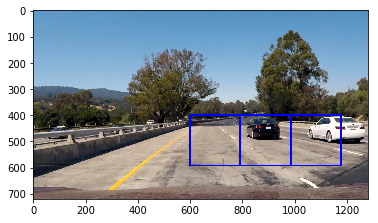

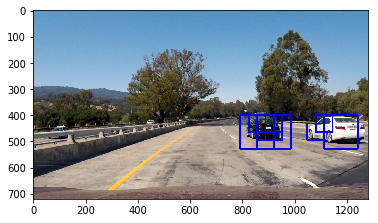

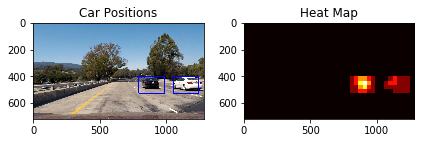

(720, 1280, 3)


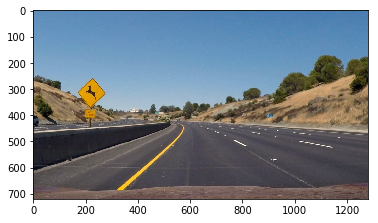

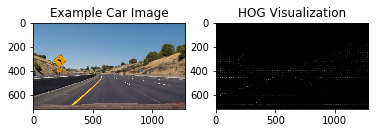

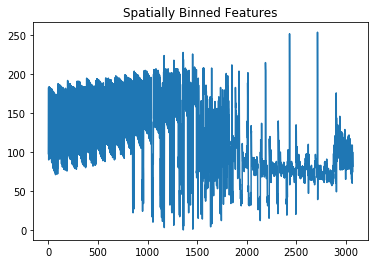

Windows sizing small


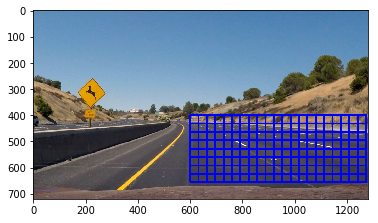

Windows sizing medium


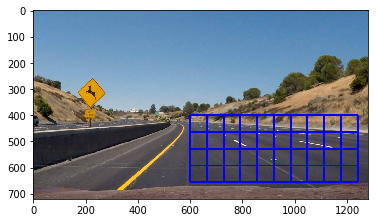

Windows sizing large


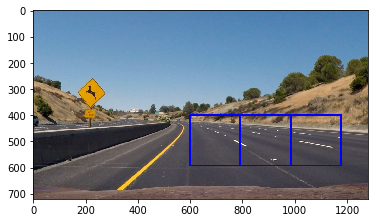

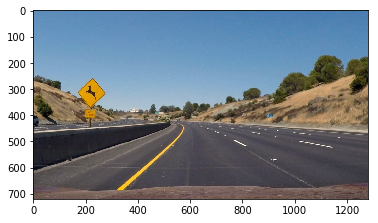

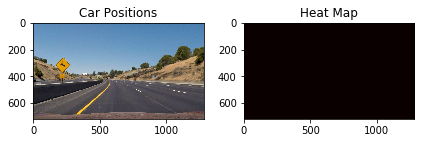

(720, 1280, 3)


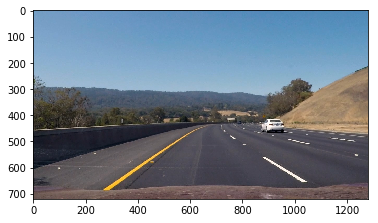

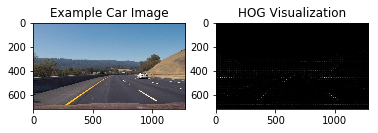

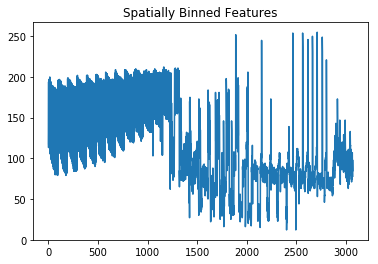

Windows sizing small


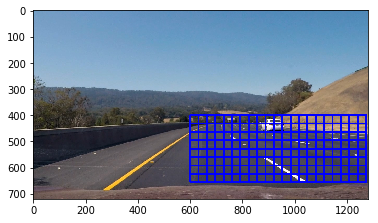

Windows sizing medium


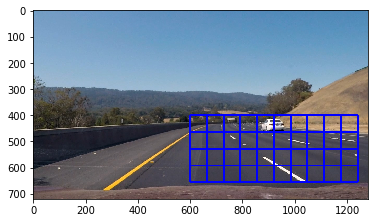

Windows sizing large


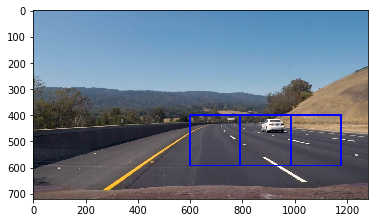

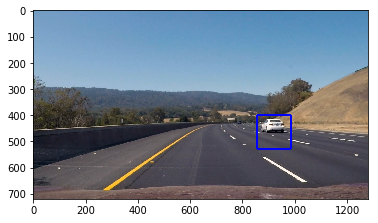

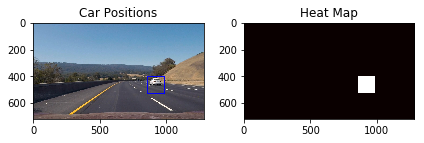

(720, 1280, 3)


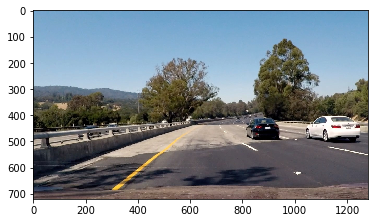

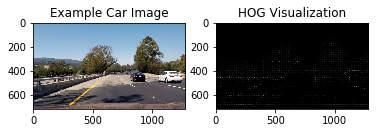

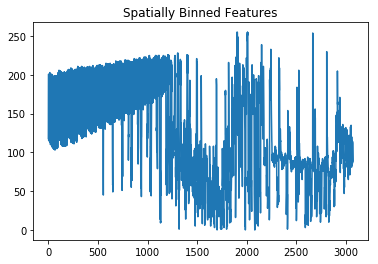

Windows sizing small


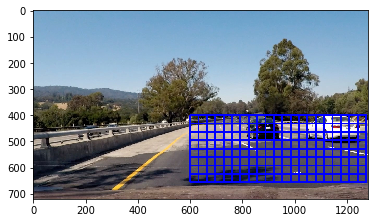

Windows sizing medium


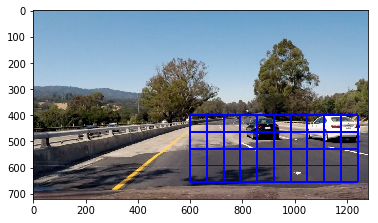

Windows sizing large


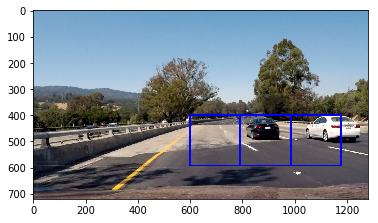

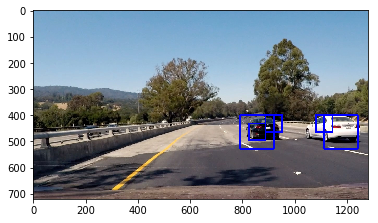

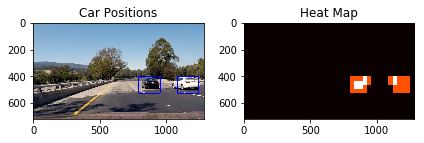

(720, 1280, 3)


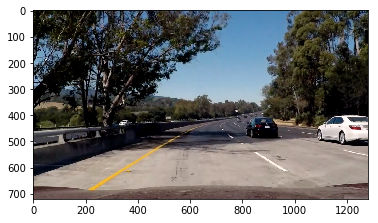

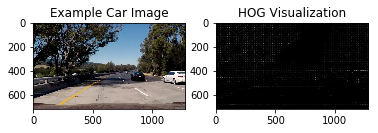

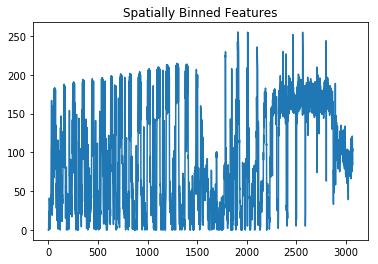

Windows sizing small


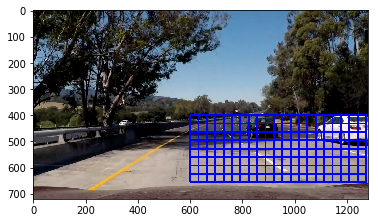

Windows sizing medium


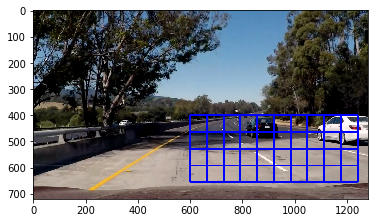

Windows sizing large


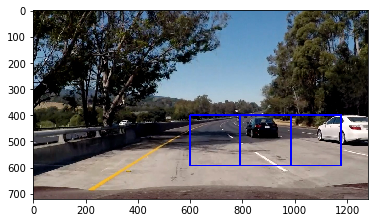

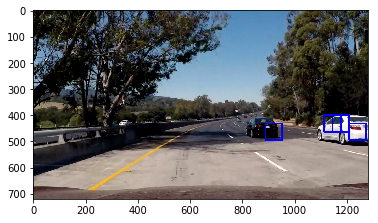

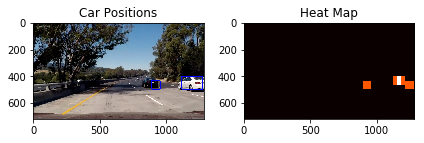

(720, 1280, 3)


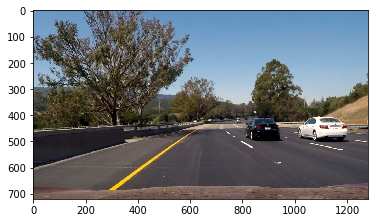

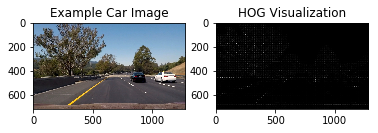

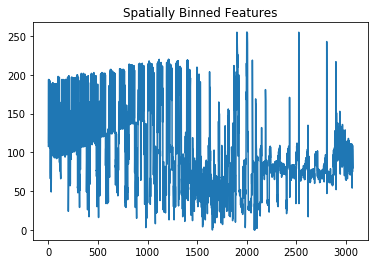

Windows sizing small


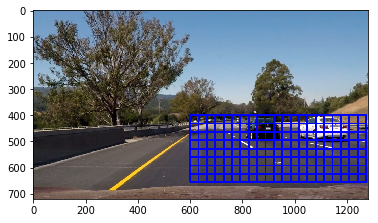

Windows sizing medium


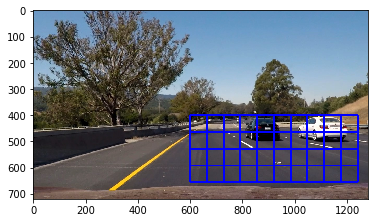

Windows sizing large


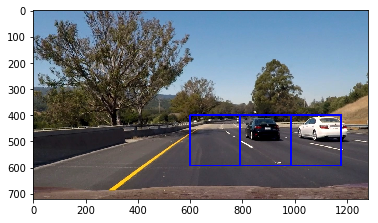

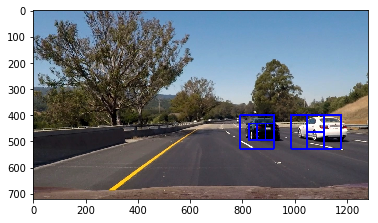

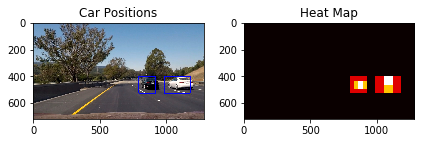

In [16]:
global DEBUG
DEBUG = True

images = load_images("./test_images/*.jpg")

i = 0
for image in images:
    global heatmap_history
    heatmap_history = deque(maxlen=10)
    i += 1
    global fname
    fname = "./output_images/test_%s" % i
    image_processing_pipeline(image)

In [17]:
def process_image(image):
    result = image_processing_pipeline(image)
    return result

In [18]:
def process_video(input_video_filepath, output_video_filepath):
    clip = VideoFileClip(input_video_filepath)
    processed_clip = clip.fl_image(process_image)
    %time processed_clip.write_videofile(output_video_filepath, audio=False)

In [19]:
global DEBUG
DEBUG = False
global heatmap_history
heatmap_history = deque(maxlen=10)

process_video("project_video.mp4", "project_video_output.mp4")

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [46:58<00:04,  4.61s/it]    


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 16min 29s, sys: 50.7 s, total: 17min 20s
Wall time: 47min 6s


In [20]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format("project_video_output.mp4"))